In [1]:
import tensorflow as tf
from datetime import datetime
import os 
import numpy as np
import sys
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import cv2
import tensorflow.keras.backend as K
from tensorflow.keras.regularizers import l1

In [2]:
class training:
    def __init__(self):
        #self.model = self.getModel()
        #self.model.summary()

        #self.optimizer = tf.keras.optimizers.Adam(lr=1e-3)
        self.activation = 'relu'
        self.optimizer = tf.keras.optimizers.Adam()
        #self.model.compile(self.optimizer, loss = 'mse', metrics = ['accuracy'] )
        #self.model.summary()
        
        #self.preMadeModel = self.get_eye_tracker_model()
        self.preMadeModel = self.getModel()
        self.preMadeModel.compile(self.optimizer, loss = 'mse', metrics = [self.myAccuracy])
    
    def myAccuracy(self, y_true, y_pred):
        diff = K.abs(y_true-y_pred) #absolute difference between correct and predicted values
        correct = K.less(diff,0.05) #tensor with 0 for false values and 1 for true values
        return K.mean(correct) #sum all 1's and divide by the total.
    
    def getModel(self):
        leftEyeInput = tf.keras.layers.Input(shape = (64,64,3))
        a = tf.keras.layers.Conv2D(96, kernel_size = 11, strides = 4, activation = self.activation, kernel_regularizer = l1(0.01), bias_regularizer = l1(0.01))(leftEyeInput)
        a = tf.keras.layers.MaxPooling2D(pool_size = 3, strides = 2)(a)
        a = tf.keras.layers.BatchNormalization()(a)
        #a = tf.keras.layers.Conv2D(256, kernel_size = 5, activation = self.activation)(a)
        #a = tf.keras.layers.MaxPooling2D(pool_size = 3, strides = 2)(a)
        #a = tf.keras.layers.BatchNormalization()(a)
        #a = tf.keras.layers.Conv2D(384, kernel_size = 3, activation = self.activation)(a)
        #a = tf.keras.layers.Conv2D(64, kernel_size = 11, strides = 4, activation = self.activation)(a)
        a = tf.keras.layers.Flatten()(a)
        lModel = tf.keras.models.Model(inputs = leftEyeInput, outputs = a)

        rightEyeInput = tf.keras.layers.Input(shape = (64,64,3))
        b = tf.keras.layers.Conv2D(96, kernel_size = 11, strides = 4, activation = self.activation, kernel_regularizer = l1(0.01), bias_regularizer = l1(0.01))(rightEyeInput)
        b = tf.keras.layers.MaxPooling2D(pool_size = 3, strides = 2)(b)
        b = tf.keras.layers.BatchNormalization()(b)
        #b = tf.keras.layers.Conv2D(256, kernel_size = 5, activation = self.activation)(b)
        #b = tf.keras.layers.MaxPooling2D(pool_size = 3, strides = 2)(b)
        #b = tf.keras.layers.BatchNormalization()(b)
        #b = tf.keras.layers.Conv2D(384, kernel_size = 3, activation = self.activation)(b)
        #b = tf.keras.layers.Conv2D(64, kernel_size = 11, strides = 4, activation = self.activation)(b)
        b = tf.keras.layers.Flatten()(b)
        rModel = tf.keras.models.Model(inputs = rightEyeInput, outputs = b)


        outEyes = tf.keras.layers.concatenate([rModel.output, lModel.output])
        outEyes = tf.keras.layers.Dense(128, activation = self.activation, kernel_regularizer = l1(0.01), bias_regularizer = l1(0.01))(outEyes)

        #Face
        faceInput = tf.keras.layers.Input(shape = (64,64,3))
        c = tf.keras.layers.Conv2D(96, kernel_size = 11, strides = 4, activation = self.activation, kernel_regularizer = l1(0.01), bias_regularizer = l1(0.01))(faceInput)
        c = tf.keras.layers.MaxPooling2D(pool_size = 3, strides = 2)(c)
        c = tf.keras.layers.BatchNormalization()(c)
        #c = tf.keras.layers.Conv2D(256, kernel_size = 5, activation = self.activation)(c)
        #c = tf.keras.layers.MaxPooling2D(pool_size = 3, strides = 2)(c)
        #c = tf.keras.layers.BatchNormalization()(c)
        #c = tf.keras.layers.Conv2D(384, kernel_size = 3, activation = self.activation)(c)
        #c = tf.keras.layers.Conv2D(64, kernel_size = 11, strides = 4, activation = self.activation)(c)
        c = tf.keras.layers.Flatten()(c)
        fModel = tf.keras.models.Model(inputs = faceInput, outputs = c)

        #Face Grid
        faceGridInput = tf.keras.layers.Input(shape = (25,25))
        d = tf.keras.layers.Flatten()(faceGridInput)
        gModel = tf.keras.models.Model(inputs = faceGridInput, outputs = d)

        outFace = tf.keras.layers.concatenate([fModel.output, gModel.output])
        outFace = tf.keras.layers.Dense(128, activation = self.activation, kernel_regularizer = l1(0.01), bias_regularizer = l1(0.01))(outFace)

        finalModel = tf.keras.layers.concatenate([outFace, outEyes])
        finalModel = tf.keras.layers.Dense(128, activation = self.activation, kernel_regularizer = l1(0.01), bias_regularizer = l1(0.01))(finalModel)
        finalModel = tf.keras.layers.Dropout(0.4)(finalModel)
        finalModel = tf.keras.layers.Dense(2)(finalModel)


        model = tf.keras.models.Model(inputs = [leftEyeInput, rightEyeInput, faceInput, faceGridInput], outputs = finalModel)

        return model
    
    def get_eye_model(self):
        eye_img_input = tf.keras.layers.Input(shape=(64,64,3))
    
        h = tf.keras.layers.Conv2D(96, (11, 11), activation=self.activation)(eye_img_input)
        h = tf.keras.layers.MaxPool2D(pool_size=(2, 2))(h)
        h = tf.keras.layers.Conv2D(256, (5, 5), activation=self.activation)(h)
        h = tf.keras.layers.MaxPool2D(pool_size=(2, 2))(h)
        h = tf.keras.layers.Conv2D(384, (3, 3), activation=self.activation)(h)
        h = tf.keras.layers.MaxPool2D(pool_size=(2, 2))(h)
        out = tf.keras.layers.Conv2D(64, (1, 1), activation=self.activation)(h)
    
        model = tf.keras.models.Model(inputs=eye_img_input, outputs=out)
    
        return model

    # face model
    def get_face_model(self):
        face_img_input = tf.keras.layers.Input(shape=(64,64,3))
    
        h = tf.keras.layers.Conv2D(96, (11, 11), activation=self.activation)(face_img_input)
        h = tf.keras.layers.MaxPool2D(pool_size=(2, 2))(h)
        h = tf.keras.layers.Conv2D(256, (5, 5), activation=self.activation)(h)
        h = tf.keras.layers.MaxPool2D(pool_size=(2, 2))(h)
        h = tf.keras.layers.Conv2D(384, (3, 3), activation=self.activation)(h)
        h = tf.keras.layers.MaxPool2D(pool_size=(2, 2))(h)
        out = tf.keras.layers.Conv2D(64, (1, 1), activation=self.activation)(h)
    
        model = tf.keras.models.Model(inputs=face_img_input, outputs=out)
    
        return model
    
    
    # final model
    def get_eye_tracker_model(self):
    
    
        # get partial models
        eye_net = self.get_eye_model()
        face_net_part = self.get_face_model()
    
        # right eye model
        right_eye_input = tf.keras.layers.Input(shape=(64, 64, 3))
        right_eye_net = eye_net(right_eye_input)
    
        # left eye model
        left_eye_input = tf.keras.layers.Input(shape=(64, 64, 3))
        left_eye_net = eye_net(left_eye_input)
    
        # face model
        face_input = tf.keras.layers.Input(shape=(64, 64, 3))
        face_net = face_net_part(face_input)
    
        # face grid
        face_grid = tf.keras.layers.Input(shape=(25,25))
    
        # tf.keras.layers.Dense layers for eyes
        e = tf.keras.layers.concatenate([left_eye_net, right_eye_net])
        e = tf.keras.layers.Flatten()(e)
        fc_e1 = tf.keras.layers.Dense(128, activation=self.activation)(e)
    
        # tf.keras.layers.Dense layers for face
        f = tf.keras.layers.Flatten()(face_net)
        fc_f1 = tf.keras.layers.Dense(128, activation=self.activation)(f)
        fc_f2 = tf.keras.layers.Dense(64, activation=self.activation)(fc_f1)
    
        # tf.keras.layers.Dense layers for face grid
        fg = tf.keras.layers.Flatten()(face_grid)
        fc_fg1 = tf.keras.layers.Dense(256, activation=self.activation)(fg)
        fc_fg2 = tf.keras.layers.Dense(128, activation=self.activation)(fc_fg1)
    
        # final tf.keras.layers.Dense layers
        h = tf.keras.layers.concatenate([fc_e1, fc_f2, fc_fg2])
        fc1 = tf.keras.layers.Dense(128, activation=self.activation)(h)
        fc2 = tf.keras.layers.Dense(2)(fc1)
    
        # final model
        final_model = tf.keras.models.Model(
            inputs=[right_eye_input, left_eye_input, face_input, face_grid],
            outputs=[fc2])
    
        return final_model
        

In [3]:
train = training()

In [4]:
model = train.preMadeModel
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 14, 14, 96)   34944       input_3[0][0]                    
____________________________________________________________________________________________

In [5]:
data = np.load('eye_tracker_train_and_val.npz')

In [6]:
a = data['train_eye_right'].astype('float32')
b = data['train_eye_left'].astype('float32')
c = data['train_face'].astype('float32')
d = data['train_face_mask'].astype('float32')
Y = data['train_y'].astype('float32')

val_a = data['val_eye_right'].astype('float32')
val_b = data['val_eye_left'].astype('float32')
val_c = data['val_face'].astype('float32')
val_d = data['val_face_mask'].astype('float32')
val_Y = data['val_y'].astype('float32')

print(a.shape, b.shape, c.shape, d.shape, Y.shape)

print(Y[0], val_Y[0])

((48000, 64, 64, 3), (48000, 64, 64, 3), (48000, 64, 64, 3), (48000, 25, 25), (48000, 2))
(array([2.4501677, 0.8047622], dtype=float32), array([ 1.7015493, -1.93875  ], dtype=float32))


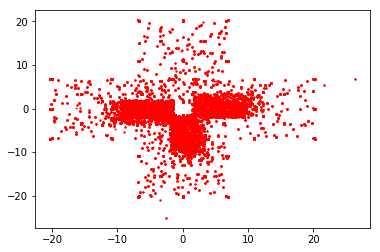

In [7]:
plt.plot(Y[:, 0], Y[:, 1], 'ro', markersize=1)

In [ ]:
logdir = "logs/scalars/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

model.load_weights('newWeights.h5')
history = model.fit([a, b, c, d],Y ,
        epochs = 100,
        validation_data = ([val_a, val_b, val_c, val_d], val_Y),
        verbose = 1,
        batch_size = 128,
        shuffle = True,
        callbacks=[tensorboard_callback]
     )

Train on 48000 samples, validate on 5000 samples
Epoch 1/100
48000/48000 [==============================] - 80s 2ms/sample - loss: 63.6158 - myAccuracy: 0.0186 - val_loss: 40.4608 - val_myAccuracy: 0.0094
Epoch 2/100
48000/48000 [==============================] - 80s 2ms/sample - loss: 23.0034 - myAccuracy: 0.0170 - val_loss: 24.9217 - val_myAccuracy: 0.0142
Epoch 3/100
48000/48000 [==============================] - 82s 2ms/sample - loss: 20.0432 - myAccuracy: 0.0158 - val_loss: 29.0565 - val_myAccuracy: 0.0087
Epoch 4/100
48000/48000 [==============================] - 84s 2ms/sample - loss: 18.5987 - myAccuracy: 0.0171 - val_loss: 28.9347 - val_myAccuracy: 0.0109
Epoch 5/100
48000/48000 [==============================] - 83s 2ms/sample - loss: 17.3051 - myAccuracy: 0.0167 - val_loss: 27.7042 - val_myAccuracy: 0.0127
Epoch 6/100
48000/48000 [==============================] - 82s 2ms/sample - loss: 16.5189 - myAccuracy: 0.0165 - val_loss: 27.1770 - val_myAccuracy: 0.0130
Epoch 7/100
480

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, color='red', label='Training loss')
plt.plot(epochs, val_loss, color='green', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
model.evaluate([val_a, val_b, val_c, val_d], val_Y,verbose = 0)

In [ ]:
test_a = val_a[1000:1010]
test_b = val_b[1000:1010]
test_c = val_c[1000:1010]
test_d = val_d[1000:1010]
prediction = train.preMadeModel.predict([test_a ,test_b ,test_c , test_d ])

n = 0
for i in range(1000,1010):
    print(data['val_y'][i], prediction[n])
    n += 1

In [ ]:
model.save_weights('newWeights.h5')